+ Requirements:
    1. The 'tools_creaVideo.py' file is required to generate virtual images.
    2. The estimated time to carry out this activity is approximately 2 hours.
<br><br>
+ Objective of the notebook:
    1. Introduction to OpenCV
    2. Analyze some classifiers
<br><br>
+ Summary of activities:
    1. To achieve these objectives, pieces of image classification code will be analyzed.

%%latex
\tableofcontents
\newpage

# Introduction
You can find some demos of classifiers in this [OpenCV link](https://docs.opencv.org/3.4/d6/de2/tutorial_py_table_of_contents_ml.html).

Below are some code examples in Python and OpenCV to extract the features of the objects of interest that allow them to be classified.

- In Python you always start by importing all the required modules:

In [1]:
import numpy as np               # the numpy module is associated with the alias np
import cv2                       # OpenCV module             
import matplotlib.pyplot as plt  # the matplotlib.pyplot with the alias plt
from IPython.display import clear_output, Image, display, HTML  
import time                      # module to mesuare time cost
import tools_creaVideo as crea   # virtual camera

In [2]:
# **** It is important to consult the help of the version you are using ****
!python --version
ip_version=!ipython --version
print('IPython:', ip_version[0])
print('Numpy:',np.__version__)
print('OpenCv:',cv2.__version__)

Python 3.8.13
IPython: 8.1.1
Numpy: 1.19.2
OpenCv: 4.5.0


- Selecting the virtual camera device:

In [3]:
#camera_dev = 'colors'
#camera_dev = 'circles'
camera_dev = 'figures'
#camera_dev = 'digits'
    
print('Device selected:', camera_dev)

Device selected: figures


Number of generated images 1
Image shape:  (288, 360, 3)
Image type: <class 'numpy.ndarray'> of uint8


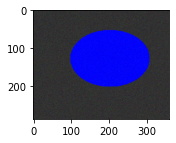

In [4]:
video = crea.VideoVirtual(camera_dev)

# Image acquisition: a BGR image is captured
ret_ok, img = video.read()
video.release()
    
if ret_ok:
    print('Image shape: ', img.shape)
    print('Image type:',type(img),'of', img.dtype)
    
    # Showing the image
    plt.figure(figsize = (3,2)) # creates a figure
    plt.imshow(img)
    
else:
    print('Error: the selected device is not available.')

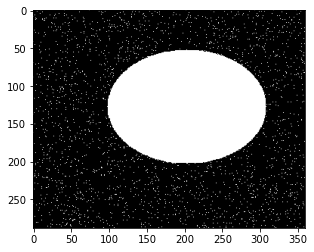

In [5]:
if ret_ok:
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
    # Otsu segmentation
    umbral, img_segmented = cv2.threshold(img_gray,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    
    # Showing segmented image
    plt.figure(figsize = (7,4)) # creates a figure
    plt.imshow(cv2.cvtColor(img_segmented, cv2.COLOR_BGR2RGB))

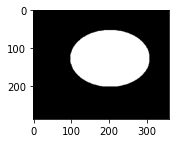

In [6]:
if ret_ok:
    # Opening image 
    kernel = np.ones((3,3),np.uint8)
    img_opened = cv2.morphologyEx(img_segmented, cv2.MORPH_OPEN, kernel)

    # Showing opened image
    plt.figure(figsize = (3,2)) # creates a figure
    plt.imshow(cv2.cvtColor(img_opened, cv2.COLOR_BGR2RGB))

## Features Extraction
Here is how to extract features from connected components.

The OpenCV function findContours detects the contours of the objects of interest in the segmented image.
You should be careful with this function because it modifies the binary image passed to it as a parameter.

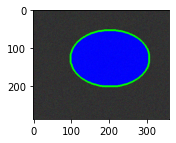

In [7]:
if ret_ok:
    # Connected-components detection by tracing contours
    contours, hierarchy = cv2.findContours(img_opened, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Drawing detected contours in green and 3 pixels wide
    img_contourns = img.copy()
    cv2.drawContours(img_contourns, contours, -1, (0,255,0), 3)
    
    # Showing original image with contours
    plt.figure(figsize = (3,2)) # creates a figure
    plt.imshow(img_contourns)
    
else:
    contours =[]

In [9]:
for cnt in contours:
    
    display_handle=display(None, display_id=True)
    # Se hace una copia de la imagen original
    img_contourns = img.copy()

    # Se visualiza cada contorno
    cv2.drawContours(img_contourns, [cnt], 0, (0,255,0), 3)
    
    area = cv2.contourArea(cnt)
    perimeter = cv2.arcLength(cnt,True)
    circularity = (4*np.pi*area)/(perimeter*perimeter)

    # Centroid
    M = cv2.moments(cnt)
    cx = int(M['m10']/M['m00'])
    cy = int(M['m01']/M['m00'])
    centroid = (cx,cy)
    
    # Basic rentangle
    rect = cv2.minAreaRect(cnt)
    box = cv2.boxPoints(rect)
    box = np.int0(box)
    cv2.drawContours(img_contourns,[box],0,(255,0,0),1)

    # Showing image with contour
    img_contourns = cv2.line(img_contourns,(cx-10,cy),(cx+10,cy),(0,255,0),3)
    img_contourns = cv2.line(img_contourns,(cx,cy-10),(cx,cy+10),(0,255,0),3)
    display_handle.update(Image(cv2.imencode('.jpg', img_contourns)[1]))
    
    print('circularity:', circularity, 'area: ', area, 'perimeter:', perimeter, 'centroid:', centroid)
    input('Press return to continue...')
    clear_output()

    display_handle.update(None)

## Dataset definition
The dataset must be iid (independent and identically distributed).

- A labeled dataset is captured with a specific number of images.

In [10]:
# Total number of images in the dataset
num_total_imgs = 100

video = crea.VideoVirtual('figuras', max_iter=num_total_imgs)

# The scene of type 'figuras' contains two classes of objects (class=1 -> circles and class=2 -> squares)
# We are going to analyze the features of area and perimeter for the two classes
# You can also analyze the feature of circularity for the two classes

features = [[],[]]

display_handle=display(None, display_id=True)
try:
    while True:
        # Capture image from virtual video which returns the label clase
        clase, img = video.read()
        
        if clase:
            
            # Image processing
            img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            umbral, img_segmented = cv2.threshold(img_gray,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
            kernel = np.ones((3,3),np.uint8)
            img_opened = cv2.morphologyEx(img_segmented, cv2.MORPH_OPEN, kernel)
            contours, hierarchy = cv2.findContours(img_opened, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

            # Features extraction
            for cnt in contours:
                area = cv2.contourArea(cnt)
                perimeter = cv2.arcLength(cnt,True)
                if perimeter > 200:
                    features[clase-1] = features[clase-1] + [[area, perimeter]]
                    #circularity = (4*np.pi*area)/(perimeter*perimeter)
                    #features[clase-1] = features[clase-1] + [[circularity]]
            
            display_handle.update(Image(data=cv2.imencode('.jpg', img)[1]))
            time.sleep(1/20) # 20 fps
        else:
            print('End of video.')
            break

except KeyboardInterrupt:
    pass
finally:
    video.release()
    display_handle.update(None)

None

End of video.
Number of generated images 100


- The dataset is divided into two. Approximately 70% of the images for training and 30% for validation.

In [11]:
# Division of the dataset into train and test
num_datos_1 = len(features[0])
num_datos_2 = len(features[1])
print('Initial data number:', num_datos_1, num_datos_2)

last_data = min(num_datos_1, num_datos_2)
num_train = int(0.7*last_data)

train_dataset = [features[0][0:num_train], features[1][0:num_train]]
test_dataset = [features[0][num_train:last_data], features[1][num_train:last_data]]
print('Number of training data:', num_train,'and test:', last_data - num_train   )

Initial data number: 57 43
Number of training data: 30 and test: 13


In [12]:
print(test_dataset)

[[[27371.0, 631.1858532428741], [27187.0, 624.4995597600937], [19854.0, 534.4163010120392], [19348.0, 526.4163008928299], [19310.0, 522.9015821218491], [28539.5, 644.2569198608398], [23593.0, 576.3574266433716], [27785.5, 627.0853487253189], [24174.5, 583.7716392278671], [25960.5, 608.6000670194626], [28641.5, 640.7422022819519], [33115.0, 685.9554047584534], [17710.5, 497.83051562309265]], [[29643.5, 710.4680362939835], [26838.5, 677.4974738359451], [25551.5, 663.4974738359451], [25389.5, 649.6984843015671], [25020.5, 646.6690467596054], [26173.5, 663.4974738359451], [28219.0, 677.798989534378], [23416.5, 620.8700572252274], [26545.5, 662.5269113779068], [25904.5, 654.6690467596054], [27846.0, 670.0], [28335.0, 674.8284270763397], [25878.5, 674.6101716756821]]]


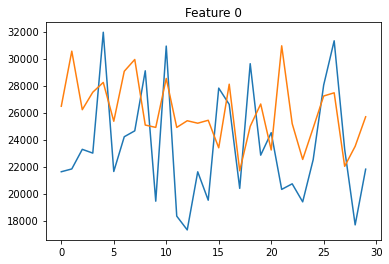

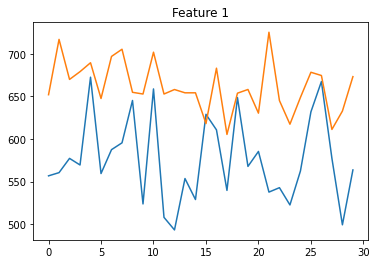

Minimum values: [17310.5          493.34524536]
Maximum valuess: [31945.5          725.29644775]


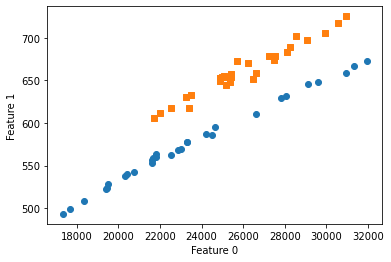

In [14]:
# The dataset is formatted

# Features of objects of interest in row format
trainData = np.asarray(train_dataset[0]+train_dataset[1]).astype(np.float32)

# Etiquetas
labels_0 = list(np.zeros(num_train))
labels_1 = list(np.ones(num_train))
trainLabels = np.asarray(labels_0+labels_1).astype(np.int32)

# To visualize the dataset we must format the data by columns
# Separating the data of each class.
datos_1 = trainData[trainLabels.ravel()==0]
datos_2 = trainData[trainLabels.ravel()==1]

# Formatting of rows is changed to columns or vice versa with transpose
datos_1_column = np.transpose(datos_1, (1, 0))
datos_2_column = np.transpose(datos_2, (1, 0))

# The features are displayed individually
num_features = len(features[0][1])
minimos = np.zeros((num_features))
maximos = np.zeros((num_features))
for i in range(num_features):
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    minimos[i]=min(min(datos_1_column[i]), min(datos_2_column[i]))
    maximos[i]=max(max(datos_1_column[i]), max(datos_2_column[i]))
    ax.plot(datos_1_column[i], color='tab:blue')
    ax.plot(datos_2_column[i], color='tab:orange')
    plt.title('Feature '+str(i) )
    plt.show()

print('Minimum values:', minimos)
print('Maximum valuess:', maximos)

# The first two features are displayed
if num_features >= 2:
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    ax.scatter(datos_1_column[0], datos_1_column[1], color='tab:blue')
    ax.scatter(datos_2_column[0], datos_2_column[1], color='tab:orange', marker='s')
    #ax.scatter(datos_2_column[0], datos_2_column[1], color='tab:orange', 's')
    ax.set_xlabel('Feature 0')
    ax.set_ylabel('Feature 1')
    plt.show()

In [15]:
# Features of objects of interest by rows
testData = np.asarray(test_dataset[0]+test_dataset[1]).astype(np.float32)

# Labels
num_test = len(test_dataset[0])
labels_0 = list(np.zeros(num_test))
labels_1 = list(np.ones(num_test))
testLabels = np.asarray(labels_0+labels_1).astype(np.int32)

In [16]:
print(testData)

[[27371.        631.18585]
 [27187.        624.4996 ]
 [19854.        534.4163 ]
 [19348.        526.4163 ]
 [19310.        522.9016 ]
 [28539.5       644.2569 ]
 [23593.        576.3574 ]
 [27785.5       627.0853 ]
 [24174.5       583.77167]
 [25960.5       608.60004]
 [28641.5       640.7422 ]
 [33115.        685.9554 ]
 [17710.5       497.8305 ]
 [29643.5       710.468  ]
 [26838.5       677.4975 ]
 [25551.5       663.4975 ]
 [25389.5       649.6985 ]
 [25020.5       646.66907]
 [26173.5       663.4975 ]
 [28219.        677.799  ]
 [23416.5       620.87006]
 [26545.5       662.5269 ]
 [25904.5       654.66907]
 [27846.        670.     ]
 [28335.        674.8284 ]
 [25878.5       674.61017]]


## Bayesian classifier

In [17]:
def get_accuracy(predictions, labels):
    """Returns the precision based on matches between predictions and labels."""
    accuracy = (np.squeeze(predictions) == labels).mean()
    return accuracy * 100

In [18]:
# A model is created and trained with train data.
model_bayes = cv2.ml.NormalBayesClassifier_create()
model_bayes.train(trainData, cv2.ml.ROW_SAMPLE, trainLabels)

True

In [19]:
# Labels of test data are predicted
predictedLabels = model_bayes.predict(testData)[1].ravel()

# Accuracy (percentage of hits) is calculated
acc = get_accuracy(predictedLabels, testLabels)
print("Percentage of hits: {} %".format("%.2f" % acc))

print('testLabels:     ', testLabels)
print('predictedLabels:', predictedLabels)

Percentage of hits: 100.00 %
testLabels:      [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1]
predictedLabels: [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1]


## KNN classifier
You can find another example of KNN at [this link](https://github.com/PacktPublishing/Mastering-OpenCV-4-with-Python/blob/master/Chapter10/01-chapter-content/knn_handwritten_digits_recognition_k_training_testing.py).

In [20]:
model_knn = cv2.ml.KNearest_create()
model_knn.train(trainData, cv2.ml.ROW_SAMPLE, trainLabels)
#model_knn.save('model_knn.dat')

True

In [21]:
#model_knn = cv2.ml.KNearest_create()
#model_knn.load('model_knn.dat')

In [22]:
# Try values of k=1, k=3, k=5, k=7, k=9
num_test = len(testData)
results=[]
for k in np.arange(1, 10, 2):
    ret, predictedLabels, neighbours, dist = model_knn.findNearest(testData, k)
    predictedLabels = np.reshape(predictedLabels, (num_test)).astype(np.int32)
    acc = get_accuracy(predictedLabels, testLabels)
    print("k=", k, "-> Percentage of hits: {} %".format("%.2f" % acc))
    
    print('        testLabels:     ', testLabels)
    print('        predictedLabels:', predictedLabels)

    results.append(acc)

k= 1 -> Percentage of hits: 65.38 %
        testLabels:      [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1]
        predictedLabels: [1 1 0 0 0 1 1 0 0 1 1 0 0 0 1 1 1 1 1 1 1 0 1 0 1 1]
k= 3 -> Percentage of hits: 69.23 %
        testLabels:      [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1]
        predictedLabels: [1 1 0 0 0 1 1 0 0 1 1 0 0 0 1 1 1 1 1 1 1 1 1 0 1 1]
k= 5 -> Percentage of hits: 73.08 %
        testLabels:      [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1]
        predictedLabels: [1 1 0 0 0 1 1 1 0 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1]
k= 7 -> Percentage of hits: 69.23 %
        testLabels:      [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1]
        predictedLabels: [1 1 0 0 0 1 0 1 1 1 1 0 0 1 1 1 1 1 1 1 0 1 1 1 1 1]
k= 9 -> Percentage of hits: 69.23 %
        testLabels:      [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1]
        predictedLabels: [1 1 0 0 0 1 0 1 1 1 1 0 0 1 1 1 1 1 1 1 0 1 1 1 1 1]


- It is very important to normalize the data.

In [23]:
# Normalized trainData in column format
trainData_col = np.transpose(trainData.copy(), (1, 0))
for i, (min, max) in enumerate(zip(minimos,maximos)):
    #print(trainData_col[i])
    #print(i,min,max)
    trainData_col[i]=np.true_divide((trainData_col[i]-min), max-min).astype(np.float32)
    #print(trainData_col[i])

# Normalized testData in column format
testData_col = np.transpose(testData.copy(), (1, 0))
for i, (min, max) in enumerate(zip(minimos,maximos)):
    #print(testData_col[i])
    #print(i,min,max)
    testData_col[i]=np.true_divide((testData_col[i]-min), max-min).astype(np.float32)
    #print(testData_col[i])

# Normalized data in row format
trainData_norm = np.transpose(trainData_col.copy(), (1, 0))
testData_norm = np.transpose(testData_col.copy(), (1, 0))

model_knn = cv2.ml.KNearest_create()
model_knn.train(trainData_norm, cv2.ml.ROW_SAMPLE, trainLabels)

True

In [24]:
# Try values of k=1, k=3, k=5, k=7, k=9
results=[]
for k in np.arange(1, 10, 2):
    ret, predictedLabels, neighbours, dist = model_knn.findNearest(testData_norm, k)
    predictedLabels = np.reshape(predictedLabels, (num_test)).astype(np.int32)
    acc = get_accuracy(predictedLabels, testLabels)
    print("k=", k, "-> Percentage of hits: {} %".format("%.2f" % acc))
    
    print('        testLabels:     ', testLabels)
    print('        predictedLabels:', predictedLabels)

    results.append(acc)

k= 1 -> Percentage of hits: 100.00 %
        testLabels:      [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1]
        predictedLabels: [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1]
k= 3 -> Percentage of hits: 100.00 %
        testLabels:      [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1]
        predictedLabels: [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1]
k= 5 -> Percentage of hits: 100.00 %
        testLabels:      [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1]
        predictedLabels: [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1]
k= 7 -> Percentage of hits: 96.15 %
        testLabels:      [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1]
        predictedLabels: [0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1]
k= 9 -> Percentage of hits: 84.62 %
        testLabels:      [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1]
        predictedLabels: [1 1 0 0 0 1 0 0 0 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1]


## SVM classifier

In [25]:
# Assign the label values to -1, 1
svm_trainLabels = trainLabels.copy()
indices = np.where(svm_trainLabels == 0)[0]
svm_trainLabels[indices] = -1

svm_testLabels = testLabels.copy()
indices = np.where(svm_testLabels == 0)[0]
svm_testLabels[indices] = -1
        
# Initialize the SVM model:
model_svm = cv2.ml.SVM_create()
model_svm.setKernel(cv2.ml.SVM_LINEAR)
#model_svm.setKernel(cv2.ml.SVM_RBF)
model_svm.setType(cv2.ml.SVM_C_SVC)
model_svm.setTermCriteria((cv2.TERM_CRITERIA_MAX_ITER, 1000, 1e-6))

c_values = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
#gamma_values = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
for c in c_values:
    #for g in gamma_values:

        #model_svm.setGamma(g)
        model_svm.setC(c)
        model_svm.train(trainData_norm, cv2.ml.ROW_SAMPLE, svm_trainLabels)

        predictedLabels = model_svm.predict(testData_norm)[1].ravel()

        acc = get_accuracy(predictedLabels, svm_testLabels)
        #print ("C=","{:7.3f}".format(c)," Gamma=","{:7.3f}".format(g),"-> Porcentaje de aciertos:", "{:7.2f} %".format(acc))
        print ("C=","{:7.3f}".format(c),"-> Percentage of hits:", "{:7.3f} %".format(acc))

        #print('svm_testLabels: ', svm_testLabels)
        #print('predictedLabels:', predictedLabels)


C=   0.001 -> Percentage of hits:  73.077 %
C=   0.010 -> Percentage of hits:  73.077 %
C=   0.100 -> Percentage of hits:  73.077 %
C=   1.000 -> Percentage of hits:  76.923 %
C=  10.000 -> Percentage of hits: 100.000 %
C= 100.000 -> Percentage of hits: 100.000 %


# Demo 1: Analysis of the perimeter estimation

In [26]:
def get_perimeter(img, tipo='4_conectividad'):
    alto, ancho = img.shape
    perimeter = 0
    for i in range(1,alto-1):
        for j in range(1,ancho-1):
            if img[i,j]==255:
                if tipo == '4_conectividad':
                    if (img[i-1,j]==0) or (img[i+1,j]==0) or (img[i,j-1]==0) or (img[i,j+1]==0):
                        perimeter = perimeter + 1
                else:
                    if ( (img[i-1,j]==0) or (img[i+1,j]==0) or (img[i,j-1]==0) or (img[i,j+1]==0) or \
                        (img[i-1,j-1]==0) or (img[i+1,j-1]==0) or (img[i-1,j+1]==0) or (img[i+1,j+1]==0)):
                        perimeter = perimeter + 1
    return perimeter

In [28]:
video = crea.VideoVirtual('circles')
scale = 4.0 
radio = int(np.sqrt( 288*360 /(scale*np.pi) ) )
perimeter_real = 2*np.pi*radio
area_real = (perimeter_real*perimeter_real)/(4*np.pi)
circularity_real=(4*np.pi*area_real)/(perimeter_real*perimeter_real)

imgs = np.zeros((288,360*2)).astype(np.uint8)
key = '0'
try:
    while len(key) > 0:
        # Genera una imagén del dispositivo VideoVirtual
        clase, img_gray = video.read()

        if clase:
            _, img_segmented = cv2.threshold(img_gray,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
            kernel = np.ones((3,3),np.uint8)
            img_opened = cv2.morphologyEx(img_segmented, cv2.MORPH_OPEN, kernel)
            
            contours, hierarchy = cv2.findContours(img_segmented, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

            # Features extraction
            for cnt in contours:
                
                img_contourns = img_gray.copy()
                cv2.drawContours(img_contourns, [cnt], 0, (0,0,0), 1)
                #img_contourns = np.squeeze(img_contourns, axis=2)
                
                area = cv2.contourArea(cnt)

                if area > 3000:
                    
                    perimeter = cv2.arcLength(cnt, True) * 0.95
                    circularity = (4*np.pi*area)/(perimeter*perimeter)
                    
                    display_handle=display(None, display_id=True)
                    print('Ideal data    : area =', "{:.2f}".format(area_real), 
                          '/ perimeter =', "{:.2f}".format(perimeter_real),
                          '/ circularity =', "{:.2f}".format(circularity_real))

                    print('Estimated data: area =', "{:.2f}".format(area),
                          '/ perimeter =', "{:.2f}".format(perimeter),
                          '/ circularity =', "{:.2f}".format(circularity))
                    
                    print('4_connectivity perimeter:', get_perimeter(img_opened, tipo='4_conectividad'))
                    print('8_connectivity perimeter:', get_perimeter(img_opened, tipo='8_conectividad'))
                    
                    imgs = np.concatenate((img_contourns, img_segmented), axis=1)
                    display_handle.update(Image(data=cv2.imencode('.jpg', imgs)[1]))

                    key = input("Press a key and return for continue... (or only return to exit)...")
                    display_handle.update(None)
                    clear_output()
        else:
            print('End of video.')
            break

except KeyboardInterrupt:
    pass
finally:
    video.release()

Number of generated images 1


# References
+ [Python documentation](https://docs.python.org/3/)
+ [Numpy documentation](https://numpy.org/doc/)
+ [Documentación de OpenCV 4.5](https://docs.opencv.org/4.5.0/)
+ [Machine Learning for OpenCV 4 - Second Edition
by Vishwesh Ravi Shrimali; Michael Beyeler; Aditya Sharma
Published by Packt Publishing, 2019](https://learning.oreilly.com/library/view/machine-learning-for/9781789536300/cover.xhtml)
+ [Machine Learning for OpenCV 4 : Intelligent Algorithms for Building Image Processing Apps Using OpenCV 4, Python, and Scikit-Learn. by Sharma, Aditya, et al. Second edition., 201](https://polibuscador.upv.es/permalink/f/6ptg6i/alma5191663190003706)